# Lab 5 Part II: Stream processing and full APRS tranciever


In this part of the lab we will take the functions that we wrote in the previous part and put them in a streaming architecture such that we can collect finite buffers and proces them in real-time. 


We found some issues with the current implementation of ax25.py. The changes we made break Lab5 part I. So in this part we will use the file newax25.py instead. 





In [2]:

# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import queue as Queue
import time
import sys

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from numpy import ones
from scipy import signal
from scipy import integrate
import threading

from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import newax25 as ax25

import multiprocessing

from math import gcd
#import sounddevice as sd
#import RPi.GPIO as GPIO
from functools import reduce
from numpy import ones,zeros, pi, cos, exp, sign




%matplotlib inline

In [3]:
# function to compute least common multipler
def lcm(numbers):
    return reduce(lambda x, y: (x*y)//gcd(x,y), numbers, 1)


In [3]:
sd.query_devices()

  0 bcm2835 ALSA: - (hw:0,0), ALSA (0 in, 2 out)
  1 bcm2835 ALSA: IEC958/HDMI (hw:0,1), ALSA (0 in, 2 out)
  2 C-Media USB Headphone Set: Audio (hw:1,0), ALSA (1 in, 2 out)
  3 sysdefault, ALSA (0 in, 128 out)
  4 dmix, ALSA (0 in, 2 out)
* 5 default, ALSA (1 in, 2 out)

In [4]:
builtin_idx = 0
usb_idx = 2
sd.default.samplerate=48000
sd.default.channels = 1

Initialize serial port

## Creating a TNC (Termina Node Controller, e.g., modem) class

The architecture we chose for this lab is to create a class that implements the functions of the modem, while keeping joint state variables such that it would be possible to process buffers in real-time while maintaining continuity and integrity of the processing as if we are processing a large buffer. 


We created the infrastructure for you, implemented in the `TNCaprs` class. 
It implelents an overlapp and save approach. The constructor for the class takes in the sampling frequency: `fs` the size of soundDevice buffer (default is 512): `Abuffer` and the number of audio buffers to collect before processing:`Nchunks`


##### `processBuffer(self, buff_in)`
The method `processBuffer(buff_in)` takes buffers in to be processed, collects them into a large buffer made of `Nchunks`. Once the large buffer has been collected, the method calls the demodulation method to create an NRZI, it calls the PLL to find the sampling timings, it samples the NRZI and converts it to NRZ bits. Finally it calls the function that looks for packets in the bitstream. 
The method implements an overlapp and save approach. So, it calls the demodulation function with a buffer that is overlaping and expects a smaller buffer, that contains only valid linear convolution samples. 

##### `demod(self, buff)` -- same as `nc_afsk1200Demod`
Because there are 3 filters one after the other in the demodulator, each one of length N, the method `processBuffer(buff_in)` sends to `demod` a buffer sized `Nchunks*Abuffer + 3*(N-1)` and expects `Nchunks*Abuffer` samples in return. If you have different size filters, you need to modify `processBuffer(buff_in)` to account for that. The filters for `demod` are generated in the `__init__` function of the `TNCaprs` class. When filtering, use `np.convolve` with `mode='valid'` so that only valid linear convolution results are returned. 

##### ` PLL(self, NRZa)`
This is the same PLL implementation as before. The only different is that the PLL counter: `pll`, its previous value: `ppll`, the stepsize: `dpll` and the agressivness or scaling factor `apll` are all class variables. This way, when the PLL finishes processing a buffer, the values are saved and used in the beginning of the next buffer

##### ` FastPLL(self, NRZa)`
The same implementation of the PLL -- but a wrapper to a C-language function. This is much faster than the one written in python

##### `findPackets(self,bits)`
This function is the same as before. The only differences are that the variables, `state`, `pktcounter`, and `packet` are class variable and their value is kept from one call to another. 

Another difference is that we also added another variable: `bitpointer`. As you recall, the function looks for flags in the bitstream up to 7 bits before the end of the buffer. `bitpointer` is needed for the case where a flag is detected at the end of the buffer and extend to these 7 bits. That means that when we process the next buffer, we need to start after those bits, and `bitpointer` points to the bit we need to start with.

##### `modulate(self, bits)` -- same as `afsk1200`
Function takes bits and afsk 1200 modulates them. The sampling rate is initialized in  `TNCaprs.__init__`

##### `modulatPacket(self, callsign, digi, dest, info, preflags=80, postflags=80 )`
        
Given callsign, digipath, dest, info, number of pre-flags and post-flags the function contructs an appropriate aprs packet, then converts them to NRZI and calls `modulate` to afsk 1200 modulate the packet. 


#### Task: 
* Convert your functions `nc_afsk1200Demod` and  `afsk1200` to `TNCaprs.demod` and `TNCaprs.modulate`. Make it into class form in which class vriables are in the form of `self.variable` which are initialized in `TNCaprs.__init__`. 














In [5]:
import numpy.ctypeslib as npct
from ctypes import c_int
from ctypes import c_float

array_1d_int = npct.ndpointer(dtype=np.int, ndim=1, flags='CONTIGUOUS')

libcd = npct.load_library("./libpll", ".")
libcd.pll.restype = c_int
libcd.pll.argtypes= [array_1d_int, c_int, array_1d_int,array_1d_int,  array_1d_int,array_1d_int, c_int, c_float]



class TNCaprs:
    
    def __init__(self, fs = 48000.0, Abuffer = 512, Nchunks=10):
        
        #  Implementation of an afsk1200 TNC. 
        #
        #  The TNC processes a `Abuffer` long buffers, till `Nchunks` number of buffers are collected into a large one.
        #  This is because python is able to more efficiently process larger buffers than smaller ones.
        #  Then, the resulting large buffer is demodulated, sampled and packets extracted.
        #
        # Inputs:
        #    fs  - sampling rate
        #   TBW  -  TBW of the demodulator filters
        #   Abuffer - Input audio buffers from Pyaudio
        #   Nchunks - Number of audio buffers to collect before processing
        #   plla    - agressivness parameter of the PLL
        
        
        ## compute sizes based on inputs
        self.TBW = 2.0   # TBW for the demod filters
        self.N = (int(fs/1200*self.TBW)//2)*2+1   # length of the mark-space filters for demod
        self.fs = fs     # sampling rate   
        self.BW = 1200      # BW of filter based on TBW
        self.Abuffer = Abuffer             # size of audio buffer
        self.Nchunks = Nchunks             # number of audio buffers to collect
        self.Nbuffer = Abuffer*Nchunks+(self.N*3-3)         # length of the large buffer for processing
        self.Ns = 1.0*fs/1200.0 # samples per symbol
        
        ## state variables for the modulator
        self.prev_ph = 0  # previous phase to maintain continuous phase when recalling the function
        
        ##  Generate Filters for the demodulator
        self.h_lp = signal.firwin(self.N,self.BW/self.fs*1.0,window='hanning')
        self.h_lpp = signal.firwin(self.N,self.BW*2*1.2/self.fs,window='hanning')
        self.h_space = self.h_lp*exp(1j*2*pi*(2200)*r_[-N/2:N/2]/self.fs)
        self.h_mark = self.h_lp*exp(1j*2*pi*(1200)*r_[-N/2:N/2]/self.fs)
        self.h_bp = (signal.firwin(self.N,self.BW/self.fs*2.2,window='hanning'))*exp(1j*2*pi*1700*r_[-self.N/2:self.N/2]/self.fs)


        ## PLL state variables  -- so conntinuity between buffers is preserved
        self.dpll = np.round(2.0**32 / self.Ns).astype(np.int32)    # PLL step
        self.pll =  0                # PLL counter
        self.ppll = -self.dpll       # PLL counter previous value -- to detect overflow
        self.plla = 0.74             # PLL agressivness (small more agressive)
        

        ## state variable to NRZI2NRZ
        self.NRZIprevBit = bool(1)  
        
        ## State variables for findPackets
        self.state='search'   # state variable:  'search' or 'pkt'
        self.pktcounter = 0   # counts the length of a packet
        self.packet = bitarray.bitarray([0,1,1,1,1,1,1,0])   # current packet being collected
        self.bitpointer = 0   # poiter to advance the search beyond what was already searched in the previous buffer

        ## State variables for processBuffer
        self.buff = zeros(self.Nbuffer)   # large overlapp-save buffer
        self.chunk_count = 0              # chunk counter
        self.oldbits = bitarray.bitarray([0,0,0,0,0,0,0])    # bits from end of prev buffer to be copied to beginning of new
        self.Npackets = 0                 # packet counter
        
        
    
    
    def NRZ2NRZI(self,NRZ, prevBit = True):
        NRZI = NRZ.copy() 
        for n in range(0,len(NRZ)):
            if NRZ[n] :
                NRZI[n] = prevBit
            else:
                NRZI[n] = not(prevBit)
            prevBit = NRZI[n]
        return NRZI
    



    def NRZI2NRZ(self, NRZI):  
        NRZ = NRZI.copy() 
    
        for n in range(0,len(NRZI)):
            NRZ[n] = NRZI[n] == self.NRZIprevBit
            self.NRZIprevBit = NRZI[n]
    
        return NRZ
    
    def KISS2bits(self,KISS):
        # function that takes a KISS frame sent via TCP/IP and converts it to an APRSpacket bit stream.
        
        bits = bitarray.bitarray(endian="little")
        bits.frombytes(KISS)
        fcs = ax25.FCS()
        for bit in bits:
            fcs.update_bit(bit)
            
        bits.frombytes(fcs.digest())
        return bitarray.bitarray('01111110') + ax25.bit_stuff(bits) + bitarray.bitarray('01111110') 
     
    def bits2KISS(self,bits):
        # function that takes a bitstream of an APRS-packet, removes flags and FCS and unstuffs the bits
        bitsu = ax25.bit_unstuff(bits[8:-8])
        return  bitsu[:-16].tobytes() 
    
    
    def modulate(self,bits):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at fs Hz
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal
    
        
        # For you to complete
        
        
        
        
        
        
        return sig 
    
    def modulatPacket(self, callsign, digi, dest, info, preflags=80, postflags=80 ):
        
        # given callsign, digipath, dest, info, number of pre-flags and post-flags the function contructs
        # an appropriate aprs packet, then converts them to NRZI and calls `modulate` to afsk 1200 modulate the packet. 
        
        packet = ax25.UI(destination=dest,source=callsign, info=info, digipeaters=digi.split(b','),)
        prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(preflags,)).tolist())
        suffix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(postflags,)).tolist())
        sig = self.modulate(self.NRZ2NRZI(prefix + packet.unparse()+suffix))

        return sig
    
    

    def demod(self, buff):
        #Demodulates a buffer and returns valid NRZ
    
        # Similar to afsk1200_demod,  for you to complete
        sig = signal.fftconvolve(sig.copy(),h_bp,'same')
        mark = abs(signal.fftconvolve(sig,h_mark,mode='same'))
        space = abs(signal.fftconvolve(sig,h_space,mode='same'))
        NRZ = mark-space
        NRZ = signal.fftconvolve(NRZ,h_lpp,'same')

        return NRZ


    def FastPLL(self,NRZa):
        recbits = np.zeros(len(NRZa)//(self.fs//1200)*2,dtype=np.int32)
        pll = np.zeros(1,dtype = np.int32)
        pll[0] = self.pll
        ppll = np.zeros(1,dtype = np.int32)
        ppll[0] = self.ppll
        
        #print("pll = ",pll,"   ppll=",ppll)
        
        
        NRZb = (NRZa > 0).astype(np.int32)
        tot = libcd.pll(NRZb,len(NRZb),recbits,recbits,pll,ppll,self.dpll,self.plla)
        
        self.ppll = ppll.copy()
        self.pll = pll.copy()
        
        #print("post: pll = ",pll,"   ppll=",ppll)
        
        return bitarray.bitarray(recbits[:tot].tolist())
    
    def PLL(self, NRZa):
       #print("running PLL")
        idx = zeros(len(NRZa)//int(self.Ns)*2)   # allocate space to save indexes        
        c = 0
        
        for n in range(1,len(NRZa)):
            if (self.pll < 0) and (self.ppll >0):
                idx[c] = n
                c = c+1
        
            if (NRZa[n] >= 0) !=  (NRZa[n-1] >=0):
                self.pll = np.int32(self.pll*self.plla)
            
        
            self.ppll = self.pll
            self.pll = np.int32(self.pll+ self.dpll)
    
        return idx[:c].astype(np.int32) 
    
   

    def findPackets(self,bits):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
        flg = bitarray.bitarray([0,1,1,1,1,1,1,0])
        packets = []
        n = self.bitpointer
        
        # Loop over bits
        while (n < len(bits)-7) :
            # default state is searching for packets
            if self.state is 'search':
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+7] == flg[1:]:
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    self.state = 'pkt'
                    self.packet=flg.copy()
                    self.pktcounter = 8
                    # Advance to the end of the flag
                    n = n + 7
                else:
                    # flag was not found, advance by 1
                    n = n + 1            
        
            # state is to collect packet data. 
            elif self.state is 'pkt':
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+7] == flg[:7]:
                    # Flag detected, check if packet is longer than some minimum
                    if self.pktcounter > 200:
                        #print('packet found!')
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flase detection and this flag could be the beginning of a real packet
                        self.state = 'search'
                        self.packet.extend(flg)
                        packets.append(self.packet.copy())
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        self.state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if self.pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer        
                        self.packet.append(bits[n])
                        self.pktcounter = self.pktcounter + 1
                        n = n + 1
                    else:  #runaway packet
                        #runaway packet, switch state to searching, and advance pointer
                        self.state = 'search'
                        n = n + 1
        
        self.bitpointer = n-(len(bits)-7) 
        return packets

    
    # function to generate a checksum for validating packets
    def genfcs(self,bits):
        # Generates a checksum from packet bits
        fcs = ax25.FCS()
        for bit in bits:
            fcs.update_bit(bit)
    
        digest = bitarray.bitarray(endian="little")
        digest.frombytes(fcs.digest())

        return digest




    # function to parse packet bits to information
    def decodeAX25(self,bits, deepsearch=False):
        ax = ax25.AX25()
        ax.info = "bad packet"
    
    
        bitsu = ax25.bit_unstuff(bits[8:-8])
    
        
        #foundPacket = False
        #if (self.genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()):
        #        foundPacket = True
        #elif deepsearch: 
        #    tbits = bits[8:-8]
        #    for n in range(0,len(tbits)):
        #        tbits[n] = not tbits[n]
        #        if (self.genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()):
        #            foundPacket = True
        #            print("Success deep search")
        #            break
        #        tbits[n] = not tbits[n]
        # 
        #if foundPacket == False:
        #    return ax
        
        if (self.genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()) == False:
            #print("failed fcs")
            return ax
                  
    
        bytes = bitsu.tobytes()
        ax.destination = ax.callsign_decode(bitsu[:56]).decode('ascii')
        source = ax.callsign_decode(bitsu[56:112]).decode('ascii')
    
        if source[-1].isdigit() and source[-1]!="0":
            ax.source = "".join((source[:-1],'-',source[-1]))
        else:
            ax.source = source[:-1]
    
        digilen=0    
    
        if bytes[14]=='\x03' and bytes[15]=='\xf0':
            digilen = 0
        else:
            for n in range(14,len(bytes)-1):
                if bytes[n] & 1:
                    digilen = (n-14)+1
                    break

        #    if digilen > 56:
        #        return ax
        ax.digipeaters =  ax.callsign_decode(bitsu[112:112+digilen*8]).decode('ascii')
        ax.info = bitsu[112+digilen*8+16:-16].tobytes()
    
    
        return ax

    def processBuffer(self, buff_in):
        
        # function processes an audio buffer. It collect several small into a large one
        # Then it demodulates and finds packets.
        #
        # The function operates as overlapp and save
        # The function returns packets when they become available. Otherwise, returns empty list
        
        N = self.N
        NN = (N*3 -3 )
        
        
        Nchunks = self.Nchunks
        Abuffer = self.Abuffer
        fs = self.fs
        Ns = self.Ns
        
        validPackets=[]
        packets=[]
        NRZI=[]
        idx = []
        bits = []
        
        # Fill in buffer at the right place
        self.buff[NN+self.chunk_count*Abuffer:NN+(self.chunk_count+1)*Abuffer] = buff_in.copy()
        self.chunk_count = self.chunk_count + 1
        
        
        # number of chunk reached -- process large buffer
        if self.chunk_count == Nchunks:
            # Demodulate to get NRZI
            NRZI = self.demod(self.buff)
            # compute sampling points, using PLL
            #idx = self.PLL(NRZI)
            # Sample and make a decision based on threshold
            #bits = bitarray.bitarray((NRZI[idx]>0).tolist())
            
            bits = self.FastPLL(NRZI)
            # In case that buffer is too small raise an error -- must have at least 7 bits worth
            if len(bits) < 7:
                raise ValueError('number of bits too small for buffer')
            
            # concatenate end of previous buffer to current one
            bits = self.oldbits + self.NRZI2NRZ(bits)
            
            # store end of bit buffer to next buffer
            self.oldbits = bits[-7:].copy()
            
            # look for packets
            packets = self.findPackets(bits)
            
            # Copy end of sample buffer to the beginning of the next (overlapp and save)
            self.buff[:NN] = self.buff[-NN:].copy()
            
            # reset chunk counter
            self.chunk_count = 0
            
            # checksum test for all detected packets
            for n in range(0,len(packets)):
                if len(packets[n]) > 200: 
                    try:
                        ax = self.decodeAX25(packets[n])
                    except:
                        ax = ax25.AX25()
                        ax.info = "bad packet"
                    if ax.info != 'bad packet':
                        validPackets.append(packets[n])
                        
            
        return validPackets

### Testing the modem reception

Now, we are ready to test our modem. Let's first load the ISS recording and see if out modem can detect the 24 packets we detected earlier. The difference is that we will load data in small buffers of 512 samples and process them over a larger buffer made several small buffers.  There are two points to make here. First: the idea is that no matter what size of buffers you use, the result of the overlapp and save should be the same. If it isn't, then you have a bug.... and beleive me... I had many before I got it right. Second: Generally, there are some overheads associated with operating on different sized buffers. The performances will varey with different architectures and memory.  We will look at several sizes and measure the time to process about 8 million samples (3min at 44.1KHz)  

#### Task:

* Load ISS.wav
* Create a TNC object using `modem = TNCaprs(fs = fs,Abuffer = 512,Nchunks = 1)`
* Process the samples with the modem, 512 samples at a time using `packets  = modem.processBuffer(sig[n:n+512])`
* The method `modem.processBuffer` will return a non-empy object whenever it detects packets. Iterate on the returned objects and display the packets.
* Repeat for `modem = TNCaprs(fs = fs,Abuffer = 512,Nchunks = 1)`. You should still get 24 packets


Basically, you will call the demodulation and decoding code every 512/44100 = 11ms.

In [13]:
fs, sig = wavread("ISS.wav")


In [14]:
Abuffer = 512
Nchunks = 1


modem = TNCaprs(fs = fs,Abuffer = Abuffer,Nchunks = Nchunks)

starttime = time.time()
npack = 0
for n in range(0,len(sig),Abuffer):
    
    packets  = modem.processBuffer(sig[n:n+Abuffer])
    for pkt in packets: 
        npack = npack + 1
        ax = modem.decodeAX25(pkt)
        infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info.decode('ascii').strip()
                    }
        print(infostr)
 
print("Processing took:", time.time()-starttime)

 1) | DEST: CQ    0 | SRC: RS0ISS | DIGI:  | ARISS - International Space Station |
 2) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | =4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH! |
 3) | DEST: CQ    0 | SRC: N7NEV  | DIGI: RS0ISSpWIDE2 2WIDE1 1 | >CQCQCQ |
 4) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | HELO VIA THE ISS |
 5) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp |  |
 6) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp |  |
 7) | DEST: ARISS p | SRC: KF1BUZ | DIGI: RS0ISSpAPRS  0WIDE2 2SGATE 0ISS   0IGATE 0PCSAT 0BEACON0 | =3932.15N/11951.16Wy.kf1buz and k1gem say hi from reno nv |
 8) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp |  |
 9) | DEST: CQ    0 | SRC: N7NEV  | DIGI: RS0ISSpWIDE2 2WIDE1 1 | >from DM43 |
 10) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | =4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH! |
 11) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | HELLO VIA THE ISS |
 12) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp | =4635.49N/12032.27W

###Task:
Repeat the task, but now use ``Nchunks = 10``. This means you will be performing demodulation and decoding on a buffer of size 512*10 corresponding to 0.12 seconds. Do you see improvement in the overallperformance?

In [19]:
Abuffer = 512
Nchunks = 10



modem = TNCaprs(fs = fs,Abuffer = Abuffer,Nchunks = Nchunks)

starttime = time.time()
npack = 0
for n in range(0,len(sig),Abuffer):
    
    packets  = modem.processBuffer(sig[n:n+Abuffer])
    for pkt in packets: 
        npack = npack + 1
        ax = modem.decodeAX25(pkt)
        infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info.strip()
                    }
        print(infostr)
print("Processing took:", time.time()-starttime)    

 1) | DEST: CQ    0 | SRC: RS0ISS | DIGI:  | b'ARISS - International Space Station' |
 2) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | b'=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!' |
 3) | DEST: CQ    0 | SRC: N7NEV  | DIGI: RS0ISSpWIDE2 2WIDE1 1 | b'>CQCQCQ' |
 4) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | b'HELO VIA THE ISS' |
 5) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp | b'' |
 6) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp | b'' |
 7) | DEST: ARISS p | SRC: KF1BUZ | DIGI: RS0ISSpAPRS  0WIDE2 2SGATE 0ISS   0IGATE 0PCSAT 0BEACON0 | b'=3932.15N/11951.16Wy.kf1buz and k1gem say hi from reno nv' |
 8) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp | b'' |
 9) | DEST: CQ    0 | SRC: N7NEV  | DIGI: RS0ISSpWIDE2 2WIDE1 1 | b'>from DM43' |
 10) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | b'=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!' |
 11) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | b'HELLO VIA THE ISS' |
 12) | DEST: CQ    0 | SRC: K7RFK  | DI

#### Task: Now, repeat for Nchunks = 20  (~1second) and Nchunks = 1000 (~10 seconds) -- the buffer size will also have associated delay before packets are presented, which in some situation can be a problem when timely response is needed. 

In [20]:
Abuffer = 512
Nchunks = 20



modem = TNCaprs(fs = fs,Abuffer = Abuffer,Nchunks = Nchunks)

starttime = time.time()
npack = 0
for n in range(0,len(sig),Abuffer):
    
    packets  = modem.processBuffer(sig[n:n+Abuffer])
    for pkt in packets: 
        npack = npack + 1
        ax = modem.decodeAX25(pkt)
        infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info.strip()
                    }
        print(infostr)
print("Processing took:", time.time()-starttime)    

 1) | DEST: CQ    0 | SRC: RS0ISS | DIGI:  | b'ARISS - International Space Station' |
 2) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | b'=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!' |
 3) | DEST: CQ    0 | SRC: N7NEV  | DIGI: RS0ISSpWIDE2 2WIDE1 1 | b'>CQCQCQ' |
 4) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | b'HELO VIA THE ISS' |
 5) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp | b'' |
 6) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp | b'' |
 7) | DEST: ARISS p | SRC: KF1BUZ | DIGI: RS0ISSpAPRS  0WIDE2 2SGATE 0ISS   0IGATE 0PCSAT 0BEACON0 | b'=3932.15N/11951.16Wy.kf1buz and k1gem say hi from reno nv' |
 8) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp | b'' |
 9) | DEST: CQ    0 | SRC: N7NEV  | DIGI: RS0ISSpWIDE2 2WIDE1 1 | b'>from DM43' |
 10) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | b'=4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH!' |
 11) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | b'HELLO VIA THE ISS' |
 12) | DEST: CQ    0 | SRC: K7RFK  | DI

### Sending files in loopback -- practice for the project

#### Task:

Write code that does the following: reads a file, breaks it into packets, modulates them and plays them on USB audio connected in loopback mode. At the same time, records the played packets, demodulates them and stores the information frame containing the data into a new file. 
Basically, a full file transfer in loopback mode -- through the usb audio. 


* Connect the interface in loopback mode
* Open the `calBlue.tiff` file as a binary file: `f = open("calBlue.tiff,"rb")`
* Create a modem using the TNCaprs with sampling rate of 48000Hz. Abuffer = 512. Nchunks = 10
* Read 256 bytes from the file at a time, create APRS packets with the 256 bytes in the information field. 
* Modulate the packets and push into a Queue named ``Qout``


In [12]:
callsign = "KK6MRI"
fname = b"calBlue.tiff"
f = open(fname,"rb")

fs = 48000
modem = TNCaprs(fs = fs ,Abuffer = 512,Nchunks = 1)
    



print("Putting packets in Queue")

# For you to complete












print("Done")
    

Putting packets in Queue
Done


* Create a replay callback similarly to Lab 4. The callback should store samples from the usb audio into a queue named ``Qin`` and also play the samples on the builtin audio, so you can hear it. 
* Start the record-play stream. While samples are being recorded and pushed to ``Qin`` in the background, read the packets from `Qout` and play each packet on the usb audio using sd.play() with ``blocking=True``







In [13]:
def queueREPLAY_callback(indata,outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata
    Qin.put( indata.copy()[:,0] )  # Global queue
    
st_replay = sd.Stream( device=(usb_idx, builtin_idx),callback=queueREPLAY_callback)
Qin = Queue.Queue()
print("Starting streams")
st_replay.start()
starttime = time.time()

# for you to complete















print("Done")
print(time.time() - starttime)

Starting streams
Done


In [14]:
print("decoding packets")
starttime = time.time()

# For you to complete

















print(time.time() - starttime)

f.close()



decoding packets
 1) | DEST: BEGIN 0 | SRC: KK6MRI | DIGI:       0 | b'calBlue.tiff' |
 2) | DEST: 0     0 | SRC: KK6MRI | DIGI:       0 | b'MM\x00*\x00\x00\x19\xa0\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x03\x00B\x00\x00B\x00\x00B\x16\x0fA\x0e\x00B\x00\x00D\x00\x00G+(Cu_8\xa8\x86/\xc5\x9d(\xd1\xa7 \xc2\x9b&wd;\x00\x00F\x00\x00B\n\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x01\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x03\x00B\x00\x00B\x0c\x04B\x19\x11B\x00\x00F\x00\x00DOE=\xa9\x8a-\xe2\xb2\x19\xfc\xc4\x08\xff\xc8\x00\xff\xc9\x00\xff\xc8\x00\xff\xcb\x00\xfb\xc8\t\x8fu2\x00\x00D\x14\rC\x01\x00B\x00\x00' |
write
 3) | DEST: 1     0 | SRC: KK6MRI | DIGI:       0 | b'B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\

 12) | DEST: 10    0 | SRC: KK6MRI | DIGI:       0 | b'B\x00\x00B\x04\x00B\x18\x10B\x00\x00E\x00\x00F(#@o\\6\x99z0\xa8\x81,\x92v450@XI<\xa4\x83/\xa9\x84,\x98z0B5?\x00\x00C\x00\x00E|i8\xfb\xc5\x0c\xfd\xc2\n\xfc\xc1\x0b\xff\xc8\x00\x94y4\x00\x00J\x91v5\xfd\xc7\x06\xff\xcb\x00\xac\x8c/\x00\x00E\n\x00B\x0c\x04B\x00\x00B\x19\x11B\x00\x00E\x8dt4\xff\xc8\x01\xfe\xc2\t\xfb\xc1\n\xfd\xc2\t\xfc\xc2\n\xfd\xc3\x0b\xff\xcc\x00\xac\x8b*\x00\x00F\x18\x10B\x00\x00B\x01\x00B\x00\x00B\x00\x00B\x00\x00B\x00\x00B\x06\x00B\x15\rB\x00\x00F*"C\x9f\x800\xde\xb3\x19\xf8\xc4\x06\xff\xc9\x00\xff\xcb\x00\xff\xcb\x00\xd4\xac\x1c\xe3\xb5\x17\xff\xcd\x00\xff\xca\x00\xff\xd0\x00\x90w4\x00\x00F\x00\x06B\xcb\xa3$\xff\xca\x00\xf8\xbe\x0e\xff\xc7\x00\xe5\xb5\x16\x00\x13DH=?\xed\xbd\x13\xff\xc9\x00\xea\xb5\x17I<A\x00\x00D\x1a\x12A\x00\x00B\x02\x00B' |
write
 13) | DEST: 11    0 | SRC: KK6MRI | DIGI:       0 | b'\x00\x00C\x11\x18B\xd3\xa9\x1d\xff\xca\x00\xfa\xbf\x0c\xfd\xc2\t\xfd\xc2\t\xfb\xc1\x0b\xff\xc7\x06\xee\xbc\x13I>

 22) | DEST: 20    0 | SRC: KK6MRI | DIGI:       0 | b'\xdf\xb3\x19\xfa\xc3\n\xfb\xc0\x0b\xff\xc7\x06\xf4\xc2\x0c\xbd\x98%mZ9\x0e\x0fF\x00\x00D\x0b\x00B\x00\x00B\x00\x00B\x00\x00B\n\x00C\x14\nC\x00\x00F0*A\xa0\x83/\xd7\xac\x1e\xf1\xbc\x0f\xfc\xc4\x00\xff\xca\x00\xff\xc8\x00\xf3\xbe\x0f\xd5\xa7\x1f\x93v2\x00\x06C\x00\x00J\x00\x00I\x00\x00IcT9\xc7\xa0$\xe1\xb0\x1a\xe1\xaf\x18\xd0\xa4!\x9b~/\x12\x1dD}i6\xde\xaf\x1a\xeb\xb8\x15\xec\xb9\x13\xe9\xb6\x16\xd9\xa9\x1c\xb9\x95)yd:\x00\x00G\x00\x00J\x00\x00H\x00\x00F\x00\x00E\x00\x00H\x00\x00J%*A\xcd\xa4!\xff\xc8\x00\xf8\xbf\x0e\xff\xc4\t\xff\xc8\x00\xff\xca\x00\xac\x8d,\x00\x00D\x00\x00B\x0e\x06B\x00\x00B\x01\x00B\x00\x00B\x04\x00B\x19\x11A\x00\x00D\x00\x00G\x19\x1dD_O=\x80d6\x82i6r]:WJ<3.B2&AbN;\x81g7\x88l4\x8aq5\x80h9\x8ft5\xae\x8b,\xb5' |
write
 23) | DEST: 21    0 | SRC: KK6MRI | DIGI:       0 | b'\x90&\xae\x8c*\xa2\x82/\xa6\x850\xa5\x85-\xba\x95\'\xd2\xa8\x1e\xc9\xa2\x1f\xbb\x96%\xa2\x84+zf7hV=oY8v^7v^9}f9\x88o5\x99{2\xb7\x91,\xc5\x9e&\xe8\

 32) | DEST: 30    0 | SRC: KK6MRI | DIGI:       0 | b'\x00n\x00\xe9\x00r\x00i\x00c\x00o\x04\x17\x040\x043\x040\x04;\x04L\x04=\x048\x049\x00 \x04?\x04@\x04>\x04D\x040\x049\x04;\x00 \x00R\x00G\x00B\x00P\x00r\x00o\x00f\x00i\x00l\x00 \x00g\x00\xe9\x00n\x00\xe9\x00r\x00i\x00q\x00u\x00e\x00 \x00R\x00V\x00B\x90\x1au(\x00 \x00R\x00G\x00B\x00 \x82r_ic\xcf\x8f\xf0\x00P\x00r\x00o\x00f\x00i\x00l\x00o\x00 \x00R\x00G\x00B\x00 \x00g\x00e\x00n\x00e\x00r\x00i\x00c\x00o\x00G\x00e\x00n\x00e\x00r\x00i\x00s\x00k\x00 \x00R\x00G\x00B\x00-\x00p\x00r\x00o\x00f\x00i\x00l\xc7|\xbc\x18\x00 \x00R\x00G\x00B\x00 \xd5\x04\xb8\\\xd3\x0c\xc7|\x00O\x00b\x00e\x00c\x00n\x00\xfd\x00 \x00R\x00G\x00B\x00 \x00p\x00r\x00o\x00f\x00i\x00l\x05\xe4\x05\xe8\x05\xd5' |
write
 33) | DEST: 31    0 | SRC: KK6MRI | DIGI:       0 | b'\x05\xe4\x05\xd9\x05\xdc\x00 \x00R\x00G\x00B\x00 \x05\xdb\x05\xdc\x05\xdc\x05\xd9\x00A\x00l\x00l\x00g\x00e\x00m\x00e\x00i\x00n\x00e\x00s\x00 \x00R\x00G\x00B\x00-\x00P\x00r\x00o\x00f\x00i\x00l\x00\xc1\x00l\x

-rwxr-xr-x 1 pi pi 8746 Mar 20 11:21 calBlue.tiff
-rw-r--r-- 1 pi pi 8746 Apr 24 08:28 rec_rec_calBlue.tiff
-rw-r--r-- 1 pi pi 8746 Apr 25 06:45 rec_calBlue.tiff


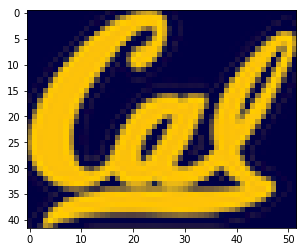

In [15]:


from PIL import Image
path = "rec_calBlue.tiff"
a = Image.open(path)
plt.imshow(a)

!ls -ltr *calBlue.tiff

### APRS Gui Application

We have reated a gui application for you. 

* Copy your TNCaprs class into the file EE123TNC.py
* Run the application from a terminal by using the commandline ``python3 EE123TNC.py``
* The modem will wait for a connection from an APRS client. 


* Download YACC (Yet another APRS Client from: http://www.ka2ddo.org/ka2ddo/YAAC.html)
* Go to configurations, expert mode. Pick PORTS and open a new one. Choose KISS-TCP. Make sure you put the address of your PI, your call sign, and enable transmit. 



* When using the radio, for best results, turn the squelch to 0 (Menue->0 then Menue again and set to 0).
* Once you get the app to work, you can play with sending EMAIL, SMS (http://www.algissalys.com/amateur-radio/aprs-services) and text messages to other classmates. Enjoy!
* To send messages and packets set the TO: field at the bottom of the maps interface to the targetted service or call sign. If you want the packet to be digipeted, then set the Via field to Wide1-1, fill in the message in the next field and press send. 
* You can either operate on the APRS frequency, decode packets and send in real time, try to communicate through the ISS, or use one of the digital channels and text your friends!


## Application

#### Below is the code stored in EE123TNC.py with some documentation. You can run it here too... but socket opening clossing and threads can get messy if something breaks. 

In [6]:
GPIO.setmode(GPIO.BOARD)
PTT = 12
GPIO.setup(PTT, GPIO.OUT, initial = 0)

In [16]:
# this is a function that runs as a thread. It take packet information from
# an APRS client through a TCP socket, creates a valid APRS packet from it 
# modulates it and plays the audio while keying the radio. 

def xmitter():
    modem = TNCaprs(fs = 48000)
    prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(40,)).tolist())
    suffix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(40,)).tolist())
    while(1):
        data = connection.recv(512)
        if data[:2] == b'\xc0\x00' :
                bits = modem.KISS2bits(data[2:-1])
                sig = modem.modulate(modem.NRZ2NRZI(prefix + bits + suffix))
                GPIO.output(PTT, GPIO.HIGH)
                time.sleep(0.4)
                sd.play(sig*0.15,samplerate=48000,device=usb_idx,  blocking=True)
                GPIO.output(PTT, GPIO.LOW)
        
    print(data)

In [8]:
# Create thread for transmitter
txer = threading.Thread(target = xmitter)

In [9]:
# Callback for receiving audio from radio and sotring the samples in a Queue

def queuereplay_callback(indata,outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata
    Qin.put_nowait( indata.copy()[:,0] )  # Global queue

### Create a TCP server 

In [23]:
import socket
import os
import sys

# code to get IP address
gw = os.popen("ip -4 route show default").read().split()
s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
s.connect((gw[2], 0))
ipaddr = s.getsockname()[0]
gateway = gw[2]
host = socket.gethostname()
print ("IP:", ipaddr, " GW:", gateway, " Host:", host)
s.close()



# Create a TCP/IP socket
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
# Bind the socket to the port
server_address = (ipaddr, 8001)
print (sys.stderr, 'starting up on %s port %s' % server_address)
sock.bind(server_address)
sock.listen(1)


connection, client_address = sock.accept()

IP: 192.168.200.182  GW: 192.168.200.1  Host: raspberrypi


In [11]:
# Start transmitter

txer.start()

In [12]:
#Create stream and Queue

Qin = Queue.Queue()

st = sd.Stream( device=(usb_idx, builtin_idx),callback=queuereplay_callback)


In [ ]:
# Start listening audio. 

st.start()

In [ ]:

# Start receiver


Abuffer = 512
Nchunks = 1
fs =48000
#modem = OLDTNCaprs(fs = fs,Abuffer = Abuffer,Nchunks = Nchunks)
#modem = TNCaprs(fs = fs,Abuffer = Abuffer,Nchunks = Nchunks, dec = 4)


modem = TNCaprs(fs = fs,Abuffer = Abuffer,Nchunks = Nchunks)
npack = 0
while (1):
        counter = 0
        while (Qin.empty()):
                if counter == 10:
                    st.stop()
                    st.close()
                    st = sd.Stream( device=(usb_idx, builtin_idx),callback=queuereplay_callback)
                    st.start()
                    counter = 0
                counter = counter + 1
                time.sleep(0.1)
                
        packets  = modem.processBuffer( Qin.get())
        for pkt in packets: 
            
            npack = npack + 1
            try:
                ax = modem.decodeAX25(pkt)
                #print(npack)
                infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info.decode("ascii").strip()
                    }
                print(infostr)
            except:
                print(npack,"packet")
            msg = b'\xc0\x00'+ modem.bits2KISS(pkt) +  b'\xc0'
            connection.sendall(msg)
            
    

 1) | DEST: APCAL p | SRC: KK6MRI-2 | DIGI: NU6XB u | :KM6QHH   :Hi From UC Berkeley{m000m |
 2) | DEST: APCAL p | SRC: KK6MRI-2 | DIGI: NU6XB u | :KM6QHH   :Hi From UC Berkeley{m000m |
3 packet
 4) | DEST: APDW13p | SRC: NU6XB  | DIGI:  | 3752.50NS12215.43W#PHG2340UC Berkeley EECS Department, RasPi + Direwolf + Baofeng |
 5) | DEST: APDW13p | SRC: NU6XB  | DIGI: WIDE1 1 | }SMSGTE>APSMS1,TCPIP,NU6XB-5*::KK6MRI-2 :@ml Hey{M8967 |
 6) | DEST: APDW13p | SRC: NU6XB  | DIGI: WIDE1 1 | }SMSGTE>APSMS1,TCPIP,NU6XB-5*::KK6MRI-2 :@ml Test{M8968 |
 7) | DEST: APDW13p | SRC: NU6XB  | DIGI: WIDE1 1 | }SMSGTE>APSMS1,TCPIP,NU6XB-5*::KK6MRI-2 :@ml Test{M8969 |
 8) | DEST: APDW13p | SRC: NU6XB  | DIGI: WIDE1 1WIDE2 1 | !3752.50NS12215.43W#PHG2340UC Berkeley EECS Department, RasPi + Direwolf + Baofeng |
 9) | DEST: APJYC1p | SRC: KM6QHH-2 | DIGI: WIDE1 1 | :SMSGTE   :@5309029622 Hey there{m000q |
 10) | DEST: APJYC1p | SRC: KM6QHH-2 | DIGI: NU6XB u | :SMSGTE   :@5309029622 Hey there{m000q |
 11) | DEST

In [25]:
connection.close()

NameError: name 'connection' is not defined

In [26]:
sock.close()

In [33]:
st.close()

In [34]:
st.stop()

In [19]:
st.close()